# Conditional VAE for LHC Olympics 2020 dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda, Input, Dense, Add, Activation, Concatenate
from tensorflow.keras.callbacks import History, ModelCheckpoint, Callback
from tensorflow.keras.optimizers import Adam, SGD

2022-12-02 15:25:21.230164: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 15:25:21.616732: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/cray/pe/papi/6.0.0.12/lib64:/opt/cray/job/2.2.4-7.0.3.1_3.24__g36b56f4.ari/lib64:/opt/intel/compilers_and_libraries_2020.2.254/linux/compiler/lib/intel64:/opt/intel/compilers_and_libraries_2020.2.254/linux/mkl/lib/intel64:/global/common/software/nersc/cori-2022q1/sw/darshan/3.4.0/lib
2022-12-02 15:25:21.616762: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do n

In [2]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

## Load training and test data

In [3]:
outerdata_train = np.load("./data/preprocessed_data_6var/outerdata_train_6var.npy")
outerdata_test = np.load("./data/preprocessed_data_6var/outerdata_test_6var.npy")

# Num of feature stored in the data files
nFeat = 6
# Num of feature we want to use for training
input_dim = 6

outerdata_train = outerdata_train[outerdata_train[:,nFeat+1]==0]
outerdata_test = outerdata_test[outerdata_test[:,nFeat+1]==0]

data_train = outerdata_train[:,1:nFeat+1]
print('shape of data_train: ', data_train.shape)
data_test = outerdata_test[:,1:nFeat+1]
print('shape of data_test: ', data_test.shape)

data = np.concatenate((data_train, data_test), axis=0)
print('shape of data: ', data.shape)

cond_data_train = outerdata_train[:,0]
print('shape of cond_train', cond_data_train.shape)
cond_data_test = outerdata_test[:,0]
print('shape of cond_test', cond_data_test.shape)

cond_data = np.concatenate((cond_data_train, cond_data_test), axis=0)
print('shape of cond_data: ', cond_data.shape)

shape of data_train:  (499889, 6)
shape of data_test:  (378759, 6)
shape of data:  (878648, 6)
shape of cond_train (499889,)
shape of cond_test (378759,)
shape of cond_data:  (878648,)


## Plot training features

- Total 6 training features
- 1 conditional feature
- Training Features are scaled to such that they are in range [0,1]

In [4]:
feature_names = {
                0: "$m_{2}$",
                1: "$\Delta m = m_{1} - m_{2}$ ",
                2: "$\\tau_{21}^{J1}$",
                3: "$\\tau_{21}^{J2}$",
                4: "$\\tau_{32}^{J1}$",
                5: "$\\tau_{32}^{J2}$"
    
}

In [5]:
feature_labels = {
                0: "Min. Jet Mass",
                1: "Jet Mass Difference",
                2: "$\\tau_{21}$ Lead Jet",
                3: "$\\tau_{21}$ Sublead Jet",
                4: "$\\tau_{32}$ Lead Jet",
                5: "$\\tau_{32}$ Sublead Jet"
    
}

In [6]:
def plot_variables(data, density = False):
    
    plt.figure(figsize=(12,12))
    if density == False:
        plt.ylabel("Events")
    else:
        plt.ylabel("Normalized events")
    
    
    for i in range(input_dim):
        plt.subplot((input_dim+1)//2, 2, i+1)
        plt.xlabel(feature_names[i])
        plt.hist(data[:, i], bins=30, color = "darkblue",  histtype = "step", label = feature_labels[i], density = density)
        plt.legend()
        plt.yscale('log')


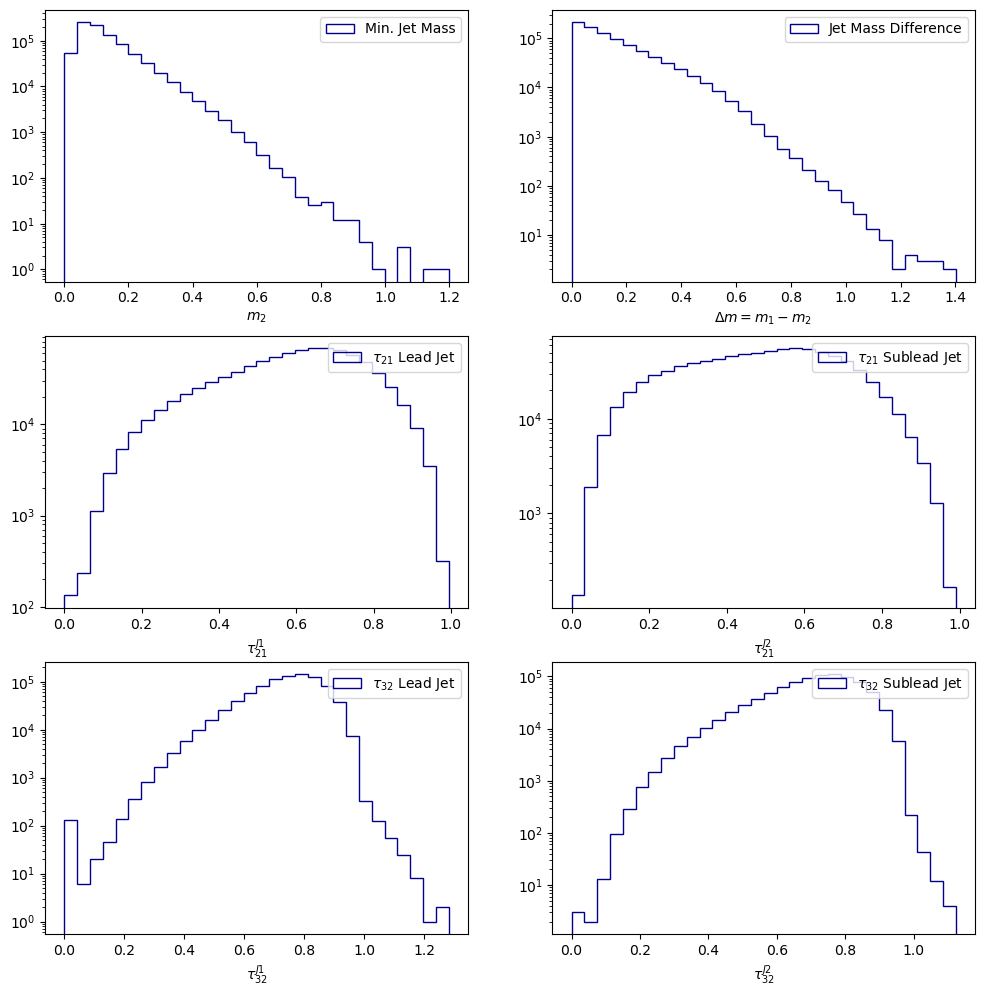

In [7]:
plot_variables(data)

### Feature scaling
Dividing each feature by the `abs(maximum)` value

In [8]:
feature_max = np.empty(nFeat)

for i in range(0,data.shape[1]):
    feature_max[i] = np.max(np.abs(data[:,i]))
    if np.abs(feature_max[i]) > 0: 
        data[:,i] = data[:,i]/feature_max[i]
    else:
        pass

cond_max = np.max(np.abs(cond_data))

if np.abs(cond_max) > 0:
    cond_data = cond_data/cond_max
else:
    pass

## Setting up for training

### Defining the train and test sets

In [9]:
trainsize = outerdata_train.shape[0]


data = data[:,0:input_dim]
data = np.reshape(data, (len(cond_data),input_dim))
print("Data Shape: ", np.shape(data))
x_train = data[:trainsize]
x_test = data[trainsize:]
y_train = cond_data[:trainsize]
y_test = cond_data[trainsize:]

# x_train = np.hstack([x_train,y_train.reshape(y_train.shape[0],1)])
# x_test = np.hstack([x_test,y_test.reshape(y_test.shape[0],1)])

image_size = x_train.shape[1]
original_dim = image_size
x_train = np.reshape(x_train, [-1, original_dim])
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
y_train = np.reshape(y_train, [-1, 1])
y_test = np.reshape(y_test, [-1, 1])
y_train = y_train.astype('float32')
y_test = y_test.astype('float32')

Data Shape:  (878648, 6)


### Network parameters

In [10]:
# network parameters
intermediate_dim = 128
encoder_dim = 128
batch_size = 1024
latent_dim = 6
epochs_1, epochs_2 = 240, 120



In [11]:

folder_name = "z6_smallModel_02-12-2022/"
comd = "mkdir -p "+"./outputs/models/"+folder_name
os.system(comd)


0

### Function for Gaussian Sampling in the VAE

In [12]:

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

### Define the Encoder 

In [13]:
def create_encoder(X,y):
    inputs = Concatenate()([X, y])
    x1 = Dense(32, activation='relu')(inputs)
    x2 = Dense(64, activation='relu')(x1)
    x3 = Dense(32, activation='relu')(x2)
    
    z_mean = Dense(latent_dim, name='z_mean')(x3)
    z_log_var = Dense(latent_dim, name='z_log_var')(x3)
    # use reparameterization trick to push the sampling out as input
    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
    
    return Model([X, y], [z_mean, z_log_var, z], name='encoder')

### Define the Decoder

In [14]:
def create_decoder(z,y):
    latent_inputs = Concatenate()([z, y])
    x1 = Dense(32, activation='relu')(latent_inputs)
    x2 = Dense(64, activation='relu')(x1)
    x3 = Dense(32, activation='relu')(x2)

    outputs = Dense(input_dim, activation='linear')(x3)

    return Model([z, y], outputs, name='decoder')

In [15]:
# instantiate encoder model
encoder = create_encoder(Input(shape=(input_dim,)), Input(shape=(1,)))
encoder.summary()


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 7)            0           ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 32)           256         ['concatenate[0][0]']      

In [16]:
# instantiate decoder model
decoder = create_decoder(Input(shape=(latent_dim,)), Input(shape=(1,)))
decoder.summary()


Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 concatenate_1 (Concatenate)    (None, 7)            0           ['input_3[0][0]',                
                                                                  'input_4[0][0]']                
                                                                                                  
 dense_3 (Dense)                (None, 32)           256         ['concatenate_1[0][0]']    

### Define the full VAE model

In [17]:
X_input = Input(shape=(input_dim,))
y_input = Input(shape=(1,))
z_mean, z_log_var, z = encoder([X_input,y_input])
outputs = decoder([z,y_input])

cvae = Model([X_input, y_input], outputs)

### Define the loss functions

In [18]:
def mse_loss_fn(x,  x_decoded_mean):
#     mse_loss = mse(x, x_decoded_mean) # objectives.mean_squared_error(x, x_decoded_mean)
    mse_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.mse(x, x_decoded_mean)
            )
        )
    return mse_loss
    
def kl_loss_fn(x,  x_decoded_mean):
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    return kl_loss
            

def vae_loss(x, x_decoded_mean):
#         mse_loss = mse(x, x_decoded_mean) # objectives.mean_squared_error(x, x_decoded_mean)
    mse_loss = mse_loss_fn(x, x_decoded_mean)
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    beta=10**(-2)  #10**(-6)
    loss = K.mean((1-beta)*mse_loss + beta*kl_loss)
#         loss = K.mean(mse_loss + kl_loss)
    return loss


### Custom Saver function

In [19]:
class CustomSaver(Callback):
    def on_epoch_end(self, epoch, logs={}):
           if (k == (iterations-1)):
               decoder.save("outputs/models/{}/model_cbvae_6var_m{}.h5".format(folder_name,epoch))
               encoder.save("outputs/models/{}/encoder_cbvae_6var_m{}.h5".format(folder_name,epoch))
decoderSaver = CustomSaver()

### Other network parameters and model compilation

In [20]:
learnrate = 0.001
iterations = 3
lr_limit = 0.001/(2**iterations)
history = History()
k=0

In [21]:
checkpointer = ModelCheckpoint(filepath='outputs/models/%s/cbvae_LHCO2020_20d_e-6.hdf5'%(folder_name), verbose=1, save_best_only=True)
opt = Adam(learning_rate=learnrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
cvae.compile(optimizer=opt, loss=vae_loss)

cvae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 encoder (Functional)           [(None, 6),          4844        ['input_5[0][0]',                
                                 (None, 6),                       'input_6[0][0]']                
                                 (None, 6)]                                                       
                                                                                              

## Training loop

In [22]:
list_loss = []
list_val_loss = [] 

while learnrate > lr_limit:
    if k < 4:
        opt = Adam(learning_rate=learnrate, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
        epochs = epochs_1
    else:
        opt = SGD(learning_rate=learnrate, decay=1e-6, momentum=0.9, nesterov=True)
        epochs = epochs_2
    cvae.compile(loss=vae_loss, optimizer=opt, metrics=[mse_loss_fn, kl_loss_fn])
    cvae.fit([x_train, y_train], x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=([x_test, y_test], x_test),
            callbacks = [checkpointer, history, decoderSaver])
    cvae.load_weights('outputs/models/%s/cbvae_LHCO2020_20d_e-6.hdf5'%(folder_name))

    learnrate /= 2
    k=k+1

list_loss = np.append(list_loss, history.history['loss'])
list_val_loss = np.append(list_val_loss, history.history['val_loss'])
    
# train the autoencoder
cvae.save_weights('outputs/models/%s/cbvae_LHCO2020_20d_e-6.h5'%(folder_name))


Train on 499889 samples, validate on 378759 samples


2022-12-02 15:25:46.991906: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-02 15:25:46.992010: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (cori03): /proc/driver/nvidia/version does not exist
2022-12-02 15:25:47.001526: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 15:25:47.090704: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Epoch 1/240
494592/499889 [============================>.] - ETA: 0s - loss: 13.4058 - mse_loss_fn: 13.2250 - kl_loss_fn: 31.2996

/global/cfs/projectdirs/atlas/elham/conda/lib/python3.8/site-packages/keras/engine/training_v1.py:2332: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates



Epoch 1: val_loss improved from inf to 1.44879, saving model to outputs/models/z6_smallModel_02-12-2022/cbvae_LHCO2020_20d_e-6.hdf5
499889/499889 [==============================] - 5s 9us/sample - loss: 13.2787 - mse_loss_fn: 13.0738 - kl_loss_fn: 31.4001 - val_loss: 1.4488 - val_mse_loss_fn: 1.0527 - val_kl_loss_fn: 40.6523
Epoch 2/240
490496/499889 [============================>.] - ETA: 0s - loss: 0.8380 - mse_loss_fn: 0.4812 - kl_loss_fn: 36.1581
Epoch 2: val_loss improved from 1.44879 to 0.39772, saving model to outputs/models/z6_smallModel_02-12-2022/cbvae_LHCO2020_20d_e-6.hdf5
499889/499889 [==============================] - 4s 8us/sample - loss: 0.8297 - mse_loss_fn: 0.4727 - kl_loss_fn: 36.0913 - val_loss: 0.3977 - val_mse_loss_fn: 0.0728 - val_kl_loss_fn: 32.5612
Epoch 3/240
499712/499889 [============================>.] - ETA: 0s - loss: 0.3690 - mse_loss_fn: 0.0640 - kl_loss_fn: 30.5704
Epoch 3: val_loss improved from 0.39772 to 0.37517, saving model to outputs/models/z6_s

Epoch 21/240
491520/499889 [============================>.] - ETA: 0s - loss: 0.2718 - mse_loss_fn: 0.0428 - kl_loss_fn: 22.9444
Epoch 21: val_loss improved from 0.28418 to 0.27642, saving model to outputs/models/z6_smallModel_02-12-2022/cbvae_LHCO2020_20d_e-6.hdf5
499889/499889 [==============================] - 4s 8us/sample - loss: 0.2717 - mse_loss_fn: 0.0426 - kl_loss_fn: 22.9425 - val_loss: 0.2764 - val_mse_loss_fn: 0.0500 - val_kl_loss_fn: 22.6939
Epoch 22/240
494592/499889 [============================>.] - ETA: 0s - loss: 0.2687 - mse_loss_fn: 0.0417 - kl_loss_fn: 22.7385
Epoch 22: val_loss improved from 0.27642 to 0.26233, saving model to outputs/models/z6_smallModel_02-12-2022/cbvae_LHCO2020_20d_e-6.hdf5
499889/499889 [==============================] - 4s 8us/sample - loss: 0.2686 - mse_loss_fn: 0.0416 - kl_loss_fn: 22.7377 - val_loss: 0.2623 - val_mse_loss_fn: 0.0372 - val_kl_loss_fn: 22.5535
Epoch 23/240
494592/499889 [============================>.] - ETA: 0s - loss: 0.26

Epoch 42/240
495616/499889 [============================>.] - ETA: 0s - loss: 0.2301 - mse_loss_fn: 0.0367 - kl_loss_fn: 19.3817
Epoch 42: val_loss improved from 0.22972 to 0.22873, saving model to outputs/models/z6_smallModel_02-12-2022/cbvae_LHCO2020_20d_e-6.hdf5
499889/499889 [==============================] - 4s 7us/sample - loss: 0.2301 - mse_loss_fn: 0.0366 - kl_loss_fn: 19.3815 - val_loss: 0.2287 - val_mse_loss_fn: 0.0368 - val_kl_loss_fn: 19.2314
Epoch 43/240
499712/499889 [============================>.] - ETA: 0s - loss: 0.2293 - mse_loss_fn: 0.0368 - kl_loss_fn: 19.2777
Epoch 43: val_loss did not improve from 0.22873
499889/499889 [==============================] - 4s 8us/sample - loss: 0.2292 - mse_loss_fn: 0.0368 - kl_loss_fn: 19.2777 - val_loss: 0.2582 - val_mse_loss_fn: 0.0673 - val_kl_loss_fn: 19.1532
Epoch 44/240
498688/499889 [============================>.] - ETA: 0s - loss: 0.2292 - mse_loss_fn: 0.0378 - kl_loss_fn: 19.1787
Epoch 44: val_loss did not improve from 0.

499889/499889 [==============================] - 4s 7us/sample - loss: 0.2178 - mse_loss_fn: 0.0353 - kl_loss_fn: 18.2781 - val_loss: 0.2252 - val_mse_loss_fn: 0.0447 - val_kl_loss_fn: 18.0935
Epoch 64/240
491520/499889 [============================>.] - ETA: 0s - loss: 0.2176 - mse_loss_fn: 0.0353 - kl_loss_fn: 18.2687
Epoch 64: val_loss did not improve from 0.21589
499889/499889 [==============================] - 4s 8us/sample - loss: 0.2176 - mse_loss_fn: 0.0353 - kl_loss_fn: 18.2680 - val_loss: 0.2654 - val_mse_loss_fn: 0.0850 - val_kl_loss_fn: 18.1232
Epoch 65/240
497664/499889 [============================>.] - ETA: 0s - loss: 0.2192 - mse_loss_fn: 0.0369 - kl_loss_fn: 18.2591
Epoch 65: val_loss did not improve from 0.21589
499889/499889 [==============================] - 4s 8us/sample - loss: 0.2191 - mse_loss_fn: 0.0369 - kl_loss_fn: 18.2591 - val_loss: 0.2246 - val_mse_loss_fn: 0.0438 - val_kl_loss_fn: 18.1211
Epoch 66/240
499712/499889 [============================>.] - ETA: 

499889/499889 [==============================] - 4s 8us/sample - loss: 0.2157 - mse_loss_fn: 0.0347 - kl_loss_fn: 18.1309 - val_loss: 0.2217 - val_mse_loss_fn: 0.0425 - val_kl_loss_fn: 17.9597
Epoch 86/240
498688/499889 [============================>.] - ETA: 0s - loss: 0.2152 - mse_loss_fn: 0.0343 - kl_loss_fn: 18.1254
Epoch 86: val_loss did not improve from 0.21434
499889/499889 [==============================] - 4s 8us/sample - loss: 0.2152 - mse_loss_fn: 0.0343 - kl_loss_fn: 18.1256 - val_loss: 0.2214 - val_mse_loss_fn: 0.0423 - val_kl_loss_fn: 17.9555
Epoch 87/240
495616/499889 [============================>.] - ETA: 0s - loss: 0.2159 - mse_loss_fn: 0.0350 - kl_loss_fn: 18.1234
Epoch 87: val_loss did not improve from 0.21434
499889/499889 [==============================] - 4s 8us/sample - loss: 0.2158 - mse_loss_fn: 0.0349 - kl_loss_fn: 18.1236 - val_loss: 0.2222 - val_mse_loss_fn: 0.0430 - val_kl_loss_fn: 17.9621
Epoch 88/240
494592/499889 [============================>.] - ETA: 

495616/499889 [============================>.] - ETA: 0s - loss: 0.2147 - mse_loss_fn: 0.0346 - kl_loss_fn: 18.0423
Epoch 107: val_loss did not improve from 0.21318
499889/499889 [==============================] - 4s 8us/sample - loss: 0.2146 - mse_loss_fn: 0.0345 - kl_loss_fn: 18.0426 - val_loss: 0.2502 - val_mse_loss_fn: 0.0714 - val_kl_loss_fn: 17.9503
Epoch 108/240
499889/499889 [==============================] - ETA: 0s - loss: 0.2151 - mse_loss_fn: 0.0350 - kl_loss_fn: 18.0369
Epoch 108: val_loss did not improve from 0.21318
499889/499889 [==============================] - 4s 8us/sample - loss: 0.2151 - mse_loss_fn: 0.0350 - kl_loss_fn: 18.0369 - val_loss: 0.2204 - val_mse_loss_fn: 0.0419 - val_kl_loss_fn: 17.8911
Epoch 109/240
493568/499889 [============================>.] - ETA: 0s - loss: 0.2142 - mse_loss_fn: 0.0341 - kl_loss_fn: 18.0360
Epoch 109: val_loss did not improve from 0.21318
499889/499889 [==============================] - 4s 8us/sample - loss: 0.2141 - mse_loss_fn

499889/499889 [==============================] - ETA: 0s - loss: 0.2139 - mse_loss_fn: 0.0343 - kl_loss_fn: 17.9916
Epoch 129: val_loss did not improve from 0.21318
499889/499889 [==============================] - 4s 8us/sample - loss: 0.2139 - mse_loss_fn: 0.0343 - kl_loss_fn: 17.9916 - val_loss: 0.2278 - val_mse_loss_fn: 0.0491 - val_kl_loss_fn: 17.9194
Epoch 130/240
496640/499889 [============================>.] - ETA: 0s - loss: 0.2142 - mse_loss_fn: 0.0346 - kl_loss_fn: 17.9914
Epoch 130: val_loss did not improve from 0.21318
499889/499889 [==============================] - 4s 8us/sample - loss: 0.2142 - mse_loss_fn: 0.0345 - kl_loss_fn: 17.9914 - val_loss: 0.2331 - val_mse_loss_fn: 0.0555 - val_kl_loss_fn: 17.8154
Epoch 131/240
499889/499889 [==============================] - ETA: 0s - loss: 0.2137 - mse_loss_fn: 0.0341 - kl_loss_fn: 17.9876
Epoch 131: val_loss did not improve from 0.21318
499889/499889 [==============================] - 4s 8us/sample - loss: 0.2137 - mse_loss_fn

499712/499889 [============================>.] - ETA: 0s - loss: 0.2132 - mse_loss_fn: 0.0339 - kl_loss_fn: 17.9683
Epoch 151: val_loss did not improve from 0.21318
499889/499889 [==============================] - 4s 8us/sample - loss: 0.2132 - mse_loss_fn: 0.0338 - kl_loss_fn: 17.9683 - val_loss: 0.2174 - val_mse_loss_fn: 0.0398 - val_kl_loss_fn: 17.7953
Epoch 152/240
491520/499889 [============================>.] - ETA: 0s - loss: 0.2133 - mse_loss_fn: 0.0341 - kl_loss_fn: 17.9624
Epoch 152: val_loss did not improve from 0.21318
499889/499889 [==============================] - 4s 8us/sample - loss: 0.2133 - mse_loss_fn: 0.0340 - kl_loss_fn: 17.9631 - val_loss: 0.2232 - val_mse_loss_fn: 0.0462 - val_kl_loss_fn: 17.7504
Epoch 153/240
492544/499889 [============================>.] - ETA: 0s - loss: 0.2134 - mse_loss_fn: 0.0341 - kl_loss_fn: 17.9654
Epoch 153: val_loss did not improve from 0.21318
499889/499889 [==============================] - 4s 8us/sample - loss: 0.2134 - mse_loss_fn

Epoch 173/240
495616/499889 [============================>.] - ETA: 0s - loss: 0.2128 - mse_loss_fn: 0.0337 - kl_loss_fn: 17.9498
Epoch 173: val_loss did not improve from 0.21307
499889/499889 [==============================] - 4s 8us/sample - loss: 0.2128 - mse_loss_fn: 0.0336 - kl_loss_fn: 17.9498 - val_loss: 0.2217 - val_mse_loss_fn: 0.0446 - val_kl_loss_fn: 17.7469
Epoch 174/240
498688/499889 [============================>.] - ETA: 0s - loss: 0.2130 - mse_loss_fn: 0.0339 - kl_loss_fn: 17.9483
Epoch 174: val_loss did not improve from 0.21307
499889/499889 [==============================] - 4s 8us/sample - loss: 0.2130 - mse_loss_fn: 0.0338 - kl_loss_fn: 17.9483 - val_loss: 0.2250 - val_mse_loss_fn: 0.0480 - val_kl_loss_fn: 17.7474
Epoch 175/240
498688/499889 [============================>.] - ETA: 0s - loss: 0.2129 - mse_loss_fn: 0.0338 - kl_loss_fn: 17.9493
Epoch 175: val_loss did not improve from 0.21307
499889/499889 [==============================] - 4s 8us/sample - loss: 0.2129

499712/499889 [============================>.] - ETA: 0s - loss: 0.2128 - mse_loss_fn: 0.0338 - kl_loss_fn: 17.9369
Epoch 195: val_loss did not improve from 0.21307
499889/499889 [==============================] - 4s 7us/sample - loss: 0.2128 - mse_loss_fn: 0.0337 - kl_loss_fn: 17.9368 - val_loss: 0.2146 - val_mse_loss_fn: 0.0374 - val_kl_loss_fn: 17.7510
Epoch 196/240
491520/499889 [============================>.] - ETA: 0s - loss: 0.2126 - mse_loss_fn: 0.0336 - kl_loss_fn: 17.9393
Epoch 196: val_loss improved from 0.21307 to 0.21217, saving model to outputs/models/z6_smallModel_02-12-2022/cbvae_LHCO2020_20d_e-6.hdf5
499889/499889 [==============================] - 4s 7us/sample - loss: 0.2126 - mse_loss_fn: 0.0335 - kl_loss_fn: 17.9392 - val_loss: 0.2122 - val_mse_loss_fn: 0.0347 - val_kl_loss_fn: 17.7843
Epoch 197/240
499712/499889 [============================>.] - ETA: 0s - loss: 0.2127 - mse_loss_fn: 0.0336 - kl_loss_fn: 17.9396
Epoch 197: val_loss did not improve from 0.21217
49

Epoch 217/240
495616/499889 [============================>.] - ETA: 0s - loss: 0.2125 - mse_loss_fn: 0.0336 - kl_loss_fn: 17.9261
Epoch 217: val_loss did not improve from 0.21186
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2125 - mse_loss_fn: 0.0335 - kl_loss_fn: 17.9260 - val_loss: 0.2181 - val_mse_loss_fn: 0.0408 - val_kl_loss_fn: 17.7725
Epoch 218/240
495616/499889 [============================>.] - ETA: 0s - loss: 0.2128 - mse_loss_fn: 0.0338 - kl_loss_fn: 17.9305
Epoch 218: val_loss did not improve from 0.21186
499889/499889 [==============================] - 3s 7us/sample - loss: 0.2128 - mse_loss_fn: 0.0337 - kl_loss_fn: 17.9306 - val_loss: 0.2300 - val_mse_loss_fn: 0.0526 - val_kl_loss_fn: 17.7932
Epoch 219/240
491520/499889 [============================>.] - ETA: 0s - loss: 0.2126 - mse_loss_fn: 0.0336 - kl_loss_fn: 17.9292
Epoch 219: val_loss did not improve from 0.21186
499889/499889 [==============================] - 3s 7us/sample - loss: 0.2125

499889/499889 [==============================] - ETA: 0s - loss: 0.2123 - mse_loss_fn: 0.0333 - kl_loss_fn: 17.9247
Epoch 239: val_loss did not improve from 0.21186
499889/499889 [==============================] - 4s 7us/sample - loss: 0.2123 - mse_loss_fn: 0.0333 - kl_loss_fn: 17.9247 - val_loss: 0.2260 - val_mse_loss_fn: 0.0483 - val_kl_loss_fn: 17.8131
Epoch 240/240
494592/499889 [============================>.] - ETA: 0s - loss: 0.2125 - mse_loss_fn: 0.0336 - kl_loss_fn: 17.9217
Epoch 240: val_loss did not improve from 0.21186
499889/499889 [==============================] - 3s 7us/sample - loss: 0.2124 - mse_loss_fn: 0.0335 - kl_loss_fn: 17.9220 - val_loss: 0.2170 - val_mse_loss_fn: 0.0399 - val_kl_loss_fn: 17.7539
Train on 499889 samples, validate on 378759 samples
Epoch 1/240
494592/499889 [============================>.] - ETA: 0s - loss: 0.2135 - mse_loss_fn: 0.0344 - kl_loss_fn: 17.9419
Epoch 1: val_loss did not improve from 0.21186
499889/499889 [============================

Epoch 21/240
492544/499889 [============================>.] - ETA: 0s - loss: 0.2109 - mse_loss_fn: 0.0319 - kl_loss_fn: 17.9292
Epoch 21: val_loss did not improve from 0.21084
499889/499889 [==============================] - 4s 8us/sample - loss: 0.2109 - mse_loss_fn: 0.0319 - kl_loss_fn: 17.9296 - val_loss: 0.2190 - val_mse_loss_fn: 0.0408 - val_kl_loss_fn: 17.8615
Epoch 22/240
491520/499889 [============================>.] - ETA: 0s - loss: 0.2109 - mse_loss_fn: 0.0319 - kl_loss_fn: 17.9289
Epoch 22: val_loss did not improve from 0.21084
499889/499889 [==============================] - 4s 7us/sample - loss: 0.2109 - mse_loss_fn: 0.0319 - kl_loss_fn: 17.9295 - val_loss: 0.2132 - val_mse_loss_fn: 0.0348 - val_kl_loss_fn: 17.8774
Epoch 23/240
494592/499889 [============================>.] - ETA: 0s - loss: 0.2110 - mse_loss_fn: 0.0320 - kl_loss_fn: 17.9318
Epoch 23: val_loss did not improve from 0.21084
499889/499889 [==============================] - 4s 7us/sample - loss: 0.2109 - mse

Epoch 43/240
499889/499889 [==============================] - ETA: 0s - loss: 0.2107 - mse_loss_fn: 0.0317 - kl_loss_fn: 17.9271
Epoch 43: val_loss did not improve from 0.21064
499889/499889 [==============================] - 3s 7us/sample - loss: 0.2107 - mse_loss_fn: 0.0317 - kl_loss_fn: 17.9271 - val_loss: 0.2138 - val_mse_loss_fn: 0.0358 - val_kl_loss_fn: 17.8296
Epoch 44/240
493568/499889 [============================>.] - ETA: 0s - loss: 0.2109 - mse_loss_fn: 0.0319 - kl_loss_fn: 17.9233
Epoch 44: val_loss did not improve from 0.21064
499889/499889 [==============================] - 4s 8us/sample - loss: 0.2108 - mse_loss_fn: 0.0319 - kl_loss_fn: 17.9227 - val_loss: 0.2116 - val_mse_loss_fn: 0.0342 - val_kl_loss_fn: 17.7726
Epoch 45/240
495616/499889 [============================>.] - ETA: 0s - loss: 0.2108 - mse_loss_fn: 0.0319 - kl_loss_fn: 17.9274
Epoch 45: val_loss did not improve from 0.21064
499889/499889 [==============================] - 4s 8us/sample - loss: 0.2108 - mse

Epoch 65/240
494592/499889 [============================>.] - ETA: 0s - loss: 0.2107 - mse_loss_fn: 0.0319 - kl_loss_fn: 17.9160
Epoch 65: val_loss did not improve from 0.21019
499889/499889 [==============================] - 4s 7us/sample - loss: 0.2107 - mse_loss_fn: 0.0318 - kl_loss_fn: 17.9165 - val_loss: 0.2109 - val_mse_loss_fn: 0.0330 - val_kl_loss_fn: 17.8268
Epoch 66/240
496640/499889 [============================>.] - ETA: 0s - loss: 0.2108 - mse_loss_fn: 0.0319 - kl_loss_fn: 17.9217
Epoch 66: val_loss did not improve from 0.21019
499889/499889 [==============================] - 4s 7us/sample - loss: 0.2108 - mse_loss_fn: 0.0319 - kl_loss_fn: 17.9220 - val_loss: 0.2160 - val_mse_loss_fn: 0.0382 - val_kl_loss_fn: 17.8252
Epoch 67/240
491520/499889 [============================>.] - ETA: 0s - loss: 0.2108 - mse_loss_fn: 0.0319 - kl_loss_fn: 17.9162
Epoch 67: val_loss did not improve from 0.21019
499889/499889 [==============================] - 4s 7us/sample - loss: 0.2107 - mse

491520/499889 [============================>.] - ETA: 0s - loss: 0.2107 - mse_loss_fn: 0.0319 - kl_loss_fn: 17.9102
Epoch 87: val_loss did not improve from 0.21019
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2107 - mse_loss_fn: 0.0319 - kl_loss_fn: 17.9110 - val_loss: 0.2113 - val_mse_loss_fn: 0.0334 - val_kl_loss_fn: 17.8199
Epoch 88/240
495616/499889 [============================>.] - ETA: 0s - loss: 0.2107 - mse_loss_fn: 0.0319 - kl_loss_fn: 17.9114
Epoch 88: val_loss did not improve from 0.21019
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2107 - mse_loss_fn: 0.0318 - kl_loss_fn: 17.9115 - val_loss: 0.2133 - val_mse_loss_fn: 0.0358 - val_kl_loss_fn: 17.7867
Epoch 89/240
492544/499889 [============================>.] - ETA: 0s - loss: 0.2107 - mse_loss_fn: 0.0319 - kl_loss_fn: 17.9081
Epoch 89: val_loss did not improve from 0.21019
499889/499889 [==============================] - 3s 7us/sample - loss: 0.2107 - mse_loss_fn: 0.0

492544/499889 [============================>.] - ETA: 0s - loss: 0.2106 - mse_loss_fn: 0.0318 - kl_loss_fn: 17.9074
Epoch 109: val_loss did not improve from 0.21019
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2106 - mse_loss_fn: 0.0318 - kl_loss_fn: 17.9078 - val_loss: 0.2136 - val_mse_loss_fn: 0.0356 - val_kl_loss_fn: 17.8311
Epoch 110/240
495616/499889 [============================>.] - ETA: 0s - loss: 0.2106 - mse_loss_fn: 0.0319 - kl_loss_fn: 17.9063
Epoch 110: val_loss did not improve from 0.21019
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2106 - mse_loss_fn: 0.0318 - kl_loss_fn: 17.9064 - val_loss: 0.2114 - val_mse_loss_fn: 0.0338 - val_kl_loss_fn: 17.8022
Epoch 111/240
493568/499889 [============================>.] - ETA: 0s - loss: 0.2106 - mse_loss_fn: 0.0318 - kl_loss_fn: 17.9101
Epoch 111: val_loss did not improve from 0.21019
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2106 - mse_loss_fn

490496/499889 [============================>.] - ETA: 0s - loss: 0.2107 - mse_loss_fn: 0.0319 - kl_loss_fn: 17.9051
Epoch 131: val_loss did not improve from 0.21019
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2107 - mse_loss_fn: 0.0319 - kl_loss_fn: 17.9059 - val_loss: 0.2143 - val_mse_loss_fn: 0.0362 - val_kl_loss_fn: 17.8467
Epoch 132/240
499712/499889 [============================>.] - ETA: 0s - loss: 0.2106 - mse_loss_fn: 0.0318 - kl_loss_fn: 17.9042
Epoch 132: val_loss did not improve from 0.21019
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2106 - mse_loss_fn: 0.0318 - kl_loss_fn: 17.9041 - val_loss: 0.2116 - val_mse_loss_fn: 0.0337 - val_kl_loss_fn: 17.8239
Epoch 133/240
490496/499889 [============================>.] - ETA: 0s - loss: 0.2105 - mse_loss_fn: 0.0318 - kl_loss_fn: 17.9035
Epoch 133: val_loss did not improve from 0.21019
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2105 - mse_loss_fn

490496/499889 [============================>.] - ETA: 0s - loss: 0.2106 - mse_loss_fn: 0.0319 - kl_loss_fn: 17.9028
Epoch 153: val_loss did not improve from 0.21019
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2106 - mse_loss_fn: 0.0318 - kl_loss_fn: 17.9036 - val_loss: 0.2119 - val_mse_loss_fn: 0.0342 - val_kl_loss_fn: 17.8047
Epoch 154/240
499889/499889 [==============================] - ETA: 0s - loss: 0.2104 - mse_loss_fn: 0.0317 - kl_loss_fn: 17.9001
Epoch 154: val_loss did not improve from 0.21019
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2104 - mse_loss_fn: 0.0317 - kl_loss_fn: 17.9001 - val_loss: 0.2108 - val_mse_loss_fn: 0.0331 - val_kl_loss_fn: 17.7997
Epoch 155/240
491520/499889 [============================>.] - ETA: 0s - loss: 0.2106 - mse_loss_fn: 0.0319 - kl_loss_fn: 17.8997
Epoch 155: val_loss did not improve from 0.21019
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2106 - mse_loss_fn

Epoch 175/240
492544/499889 [============================>.] - ETA: 0s - loss: 0.2104 - mse_loss_fn: 0.0317 - kl_loss_fn: 17.8959
Epoch 175: val_loss did not improve from 0.21010
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2104 - mse_loss_fn: 0.0317 - kl_loss_fn: 17.8957 - val_loss: 0.2124 - val_mse_loss_fn: 0.0345 - val_kl_loss_fn: 17.8227
Epoch 176/240
495616/499889 [============================>.] - ETA: 0s - loss: 0.2105 - mse_loss_fn: 0.0318 - kl_loss_fn: 17.8958
Epoch 176: val_loss did not improve from 0.21010
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2105 - mse_loss_fn: 0.0318 - kl_loss_fn: 17.8958 - val_loss: 0.2117 - val_mse_loss_fn: 0.0335 - val_kl_loss_fn: 17.8565
Epoch 177/240
498688/499889 [============================>.] - ETA: 0s - loss: 0.2104 - mse_loss_fn: 0.0317 - kl_loss_fn: 17.8984
Epoch 177: val_loss did not improve from 0.21010
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2104

498688/499889 [============================>.] - ETA: 0s - loss: 0.2105 - mse_loss_fn: 0.0318 - kl_loss_fn: 17.8946
Epoch 197: val_loss did not improve from 0.21010
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2105 - mse_loss_fn: 0.0318 - kl_loss_fn: 17.8944 - val_loss: 0.2106 - val_mse_loss_fn: 0.0330 - val_kl_loss_fn: 17.7863
Epoch 198/240
494592/499889 [============================>.] - ETA: 0s - loss: 0.2105 - mse_loss_fn: 0.0319 - kl_loss_fn: 17.8976
Epoch 198: val_loss did not improve from 0.21010
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2105 - mse_loss_fn: 0.0318 - kl_loss_fn: 17.8976 - val_loss: 0.2167 - val_mse_loss_fn: 0.0391 - val_kl_loss_fn: 17.7980
Epoch 199/240
493568/499889 [============================>.] - ETA: 0s - loss: 0.2105 - mse_loss_fn: 0.0318 - kl_loss_fn: 17.9015
Epoch 199: val_loss did not improve from 0.21010
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2105 - mse_loss_fn

493568/499889 [============================>.] - ETA: 0s - loss: 0.2103 - mse_loss_fn: 0.0318 - kl_loss_fn: 17.8906
Epoch 219: val_loss improved from 0.21010 to 0.21004, saving model to outputs/models/z6_smallModel_02-12-2022/cbvae_LHCO2020_20d_e-6.hdf5
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2103 - mse_loss_fn: 0.0317 - kl_loss_fn: 17.8914 - val_loss: 0.2100 - val_mse_loss_fn: 0.0321 - val_kl_loss_fn: 17.8264
Epoch 220/240
489472/499889 [============================>.] - ETA: 0s - loss: 0.2103 - mse_loss_fn: 0.0317 - kl_loss_fn: 17.8960
Epoch 220: val_loss did not improve from 0.21004
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2103 - mse_loss_fn: 0.0316 - kl_loss_fn: 17.8962 - val_loss: 0.2119 - val_mse_loss_fn: 0.0341 - val_kl_loss_fn: 17.8145
Epoch 221/240
490496/499889 [============================>.] - ETA: 0s - loss: 0.2105 - mse_loss_fn: 0.0318 - kl_loss_fn: 17.8987
Epoch 221: val_loss did not improve from 0.21004
49

489472/499889 [============================>.] - ETA: 0s - loss: 0.2103 - mse_loss_fn: 0.0317 - kl_loss_fn: 17.8888
Epoch 240: val_loss did not improve from 0.20963
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2103 - mse_loss_fn: 0.0317 - kl_loss_fn: 17.8893 - val_loss: 0.2144 - val_mse_loss_fn: 0.0371 - val_kl_loss_fn: 17.7659
Train on 499889 samples, validate on 378759 samples
Epoch 1/240
495616/499889 [============================>.] - ETA: 0s - loss: 0.2103 - mse_loss_fn: 0.0316 - kl_loss_fn: 17.8968
Epoch 1: val_loss did not improve from 0.20963
499889/499889 [==============================] - 3s 7us/sample - loss: 0.2103 - mse_loss_fn: 0.0316 - kl_loss_fn: 17.8969 - val_loss: 0.2102 - val_mse_loss_fn: 0.0319 - val_kl_loss_fn: 17.8638
Epoch 2/240
498688/499889 [============================>.] - ETA: 0s - loss: 0.2098 - mse_loss_fn: 0.0311 - kl_loss_fn: 17.8936
Epoch 2: val_loss did not improve from 0.20963
499889/499889 [==============================] 

489472/499889 [============================>.] - ETA: 0s - loss: 0.2098 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8903
Epoch 22: val_loss did not improve from 0.20963
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2098 - mse_loss_fn: 0.0311 - kl_loss_fn: 17.8903 - val_loss: 0.2108 - val_mse_loss_fn: 0.0329 - val_kl_loss_fn: 17.8160
Epoch 23/240
493568/499889 [============================>.] - ETA: 0s - loss: 0.2098 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8886
Epoch 23: val_loss did not improve from 0.20963
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2098 - mse_loss_fn: 0.0311 - kl_loss_fn: 17.8890 - val_loss: 0.2098 - val_mse_loss_fn: 0.0316 - val_kl_loss_fn: 17.8498
Epoch 24/240
493568/499889 [============================>.] - ETA: 0s - loss: 0.2098 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8905
Epoch 24: val_loss did not improve from 0.20963
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2098 - mse_loss_fn: 0.0

Epoch 44/240
496640/499889 [============================>.] - ETA: 0s - loss: 0.2098 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8906
Epoch 44: val_loss did not improve from 0.20938
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2098 - mse_loss_fn: 0.0311 - kl_loss_fn: 17.8902 - val_loss: 0.2116 - val_mse_loss_fn: 0.0339 - val_kl_loss_fn: 17.8017
Epoch 45/240
490496/499889 [============================>.] - ETA: 0s - loss: 0.2098 - mse_loss_fn: 0.0313 - kl_loss_fn: 17.8879
Epoch 45: val_loss did not improve from 0.20938
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2098 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8880 - val_loss: 0.2103 - val_mse_loss_fn: 0.0322 - val_kl_loss_fn: 17.8367
Epoch 46/240
493568/499889 [============================>.] - ETA: 0s - loss: 0.2098 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8869
Epoch 46: val_loss did not improve from 0.20938
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2098 - mse

495616/499889 [============================>.] - ETA: 0s - loss: 0.2097 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8819
Epoch 66: val_loss did not improve from 0.20938
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2097 - mse_loss_fn: 0.0311 - kl_loss_fn: 17.8817 - val_loss: 0.2104 - val_mse_loss_fn: 0.0327 - val_kl_loss_fn: 17.8046
Epoch 67/240
496640/499889 [============================>.] - ETA: 0s - loss: 0.2097 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8831
Epoch 67: val_loss did not improve from 0.20938
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2097 - mse_loss_fn: 0.0311 - kl_loss_fn: 17.8835 - val_loss: 0.2104 - val_mse_loss_fn: 0.0326 - val_kl_loss_fn: 17.8151
Epoch 68/240
489472/499889 [============================>.] - ETA: 0s - loss: 0.2097 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8800
Epoch 68: val_loss did not improve from 0.20938
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2097 - mse_loss_fn: 0.0

490496/499889 [============================>.] - ETA: 0s - loss: 0.2097 - mse_loss_fn: 0.0313 - kl_loss_fn: 17.8770
Epoch 88: val_loss did not improve from 0.20938
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2097 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8779 - val_loss: 0.2099 - val_mse_loss_fn: 0.0318 - val_kl_loss_fn: 17.8405
Epoch 89/240
499712/499889 [============================>.] - ETA: 0s - loss: 0.2096 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8795
Epoch 89: val_loss did not improve from 0.20938
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2096 - mse_loss_fn: 0.0311 - kl_loss_fn: 17.8794 - val_loss: 0.2125 - val_mse_loss_fn: 0.0345 - val_kl_loss_fn: 17.8272
Epoch 90/240
493568/499889 [============================>.] - ETA: 0s - loss: 0.2096 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8780
Epoch 90: val_loss did not improve from 0.20938
499889/499889 [==============================] - 3s 7us/sample - loss: 0.2096 - mse_loss_fn: 0.0

492544/499889 [============================>.] - ETA: 0s - loss: 0.2096 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8747
Epoch 110: val_loss did not improve from 0.20938
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2096 - mse_loss_fn: 0.0311 - kl_loss_fn: 17.8752 - val_loss: 0.2099 - val_mse_loss_fn: 0.0318 - val_kl_loss_fn: 17.8396
Epoch 111/240
494592/499889 [============================>.] - ETA: 0s - loss: 0.2097 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8788
Epoch 111: val_loss did not improve from 0.20938
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2097 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8786 - val_loss: 0.2116 - val_mse_loss_fn: 0.0339 - val_kl_loss_fn: 17.8037
Epoch 112/240
498688/499889 [============================>.] - ETA: 0s - loss: 0.2098 - mse_loss_fn: 0.0313 - kl_loss_fn: 17.8816
Epoch 112: val_loss did not improve from 0.20938
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2098 - mse_loss_fn

497664/499889 [============================>.] - ETA: 0s - loss: 0.2096 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8689
Epoch 132: val_loss did not improve from 0.20938
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2095 - mse_loss_fn: 0.0311 - kl_loss_fn: 17.8687 - val_loss: 0.2100 - val_mse_loss_fn: 0.0322 - val_kl_loss_fn: 17.8084
Epoch 133/240
499712/499889 [============================>.] - ETA: 0s - loss: 0.2095 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8672
Epoch 133: val_loss did not improve from 0.20938
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2095 - mse_loss_fn: 0.0311 - kl_loss_fn: 17.8673 - val_loss: 0.2102 - val_mse_loss_fn: 0.0321 - val_kl_loss_fn: 17.8389
Epoch 134/240
488448/499889 [============================>.] - ETA: 0s - loss: 0.2095 - mse_loss_fn: 0.0311 - kl_loss_fn: 17.8673
Epoch 134: val_loss did not improve from 0.20938
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2095 - mse_loss_fn

494592/499889 [============================>.] - ETA: 0s - loss: 0.2095 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8660
Epoch 154: val_loss did not improve from 0.20938
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2095 - mse_loss_fn: 0.0311 - kl_loss_fn: 17.8658 - val_loss: 0.2096 - val_mse_loss_fn: 0.0318 - val_kl_loss_fn: 17.8136
Epoch 155/240
490496/499889 [============================>.] - ETA: 0s - loss: 0.2096 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8648
Epoch 155: val_loss did not improve from 0.20938
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2096 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8642 - val_loss: 0.2117 - val_mse_loss_fn: 0.0343 - val_kl_loss_fn: 17.7815
Epoch 156/240
497664/499889 [============================>.] - ETA: 0s - loss: 0.2096 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8642
Epoch 156: val_loss did not improve from 0.20938
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2096 - mse_loss_fn

Epoch 176/240
492544/499889 [============================>.] - ETA: 0s - loss: 0.2095 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8612
Epoch 176: val_loss did not improve from 0.20937
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2095 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8613 - val_loss: 0.2113 - val_mse_loss_fn: 0.0335 - val_kl_loss_fn: 17.8144
Epoch 177/240
490496/499889 [============================>.] - ETA: 0s - loss: 0.2095 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8582
Epoch 177: val_loss did not improve from 0.20937
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2095 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8591 - val_loss: 0.2106 - val_mse_loss_fn: 0.0328 - val_kl_loss_fn: 17.8198
Epoch 178/240
489472/499889 [============================>.] - ETA: 0s - loss: 0.2095 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8608
Epoch 178: val_loss did not improve from 0.20937
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2095

Epoch 198/240
489472/499889 [============================>.] - ETA: 0s - loss: 0.2096 - mse_loss_fn: 0.0313 - kl_loss_fn: 17.8615
Epoch 198: val_loss did not improve from 0.20933
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2096 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8620 - val_loss: 0.2098 - val_mse_loss_fn: 0.0320 - val_kl_loss_fn: 17.8112
Epoch 199/240
496640/499889 [============================>.] - ETA: 0s - loss: 0.2095 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8585
Epoch 199: val_loss did not improve from 0.20933
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2095 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8582 - val_loss: 0.2105 - val_mse_loss_fn: 0.0329 - val_kl_loss_fn: 17.7929
Epoch 200/240
491520/499889 [============================>.] - ETA: 0s - loss: 0.2095 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8584
Epoch 200: val_loss did not improve from 0.20933
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2095

Epoch 220/240
493568/499889 [============================>.] - ETA: 0s - loss: 0.2095 - mse_loss_fn: 0.0313 - kl_loss_fn: 17.8578
Epoch 220: val_loss did not improve from 0.20927
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2095 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8575 - val_loss: 0.2095 - val_mse_loss_fn: 0.0319 - val_kl_loss_fn: 17.7904
Epoch 221/240
492544/499889 [============================>.] - ETA: 0s - loss: 0.2094 - mse_loss_fn: 0.0312 - kl_loss_fn: 17.8554
Epoch 221: val_loss did not improve from 0.20927
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2094 - mse_loss_fn: 0.0311 - kl_loss_fn: 17.8558 - val_loss: 0.2101 - val_mse_loss_fn: 0.0323 - val_kl_loss_fn: 17.8087
Epoch 222/240
488448/499889 [============================>.] - ETA: 0s - loss: 0.2095 - mse_loss_fn: 0.0313 - kl_loss_fn: 17.8527
Epoch 222: val_loss did not improve from 0.20927
499889/499889 [==============================] - 3s 6us/sample - loss: 0.2095

In [23]:
# Predict the mean and std from the training dataset
# latent mean
latent_mean = encoder.predict([x_train, y_train])[0]
# latent log variance --> variance --> std
latent_logvar = encoder.predict([x_train, y_train])[1]
latent_var = np.exp(latent_logvar)
latent_std = np.sqrt(latent_var)

# Save the latent mean and atd values
np.savetxt('outputs/models/%s/cbvae_LHCO2020_latent_mean_20d_e-6.csv'%folder_name, latent_mean)
np.savetxt('outputs/models/%s/cbvae_LHCO2020_latent_std_20d_e-6.csv'%folder_name, latent_std)

# Save the loss values
np.save("outputs/models/%s/cbvae_LHCO2020_val_loss.npy"%folder_name, list_val_loss)
np.save("outputs/models/%s/cbvae_LHCO2020_train_loss.npy"%folder_name, list_loss)

/global/cfs/projectdirs/atlas/elham/conda/lib/python3.8/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [24]:
list_val_loss

array([1.44878777, 0.39771963, 0.3751677 , 0.35092922, 0.33497851,
       0.31206627, 0.38703952, 0.31556758, 0.31097482, 0.29695632,
       0.2948337 , 0.30349879, 0.28738432, 0.29035154, 0.30063606,
       0.28417653, 0.28904413, 0.36474683, 0.31934964, 0.30763028,
       0.27642078, 0.26232924, 0.30331878, 0.27517328, 0.27721729,
       0.29564568, 0.29738049, 0.28267259, 0.24986311, 0.25816242,
       0.27683339, 0.27688566, 0.25212226, 0.25394825, 0.26239371,
       0.24757256, 0.28879086, 0.2393936 , 0.24085919, 0.26693329,
       0.22971952, 0.2287277 , 0.25815253, 0.25915465, 0.24033146,
       0.28054477, 0.23588254, 0.25699037, 0.2222717 , 0.23449427,
       0.2325394 , 0.23069464, 0.22336635, 0.22883094, 0.23981587,
       0.22774893, 0.24837769, 0.2340351 , 0.23024131, 0.22577997,
       0.21588705, 0.22929635, 0.22515472, 0.26539125, 0.22455748,
       0.25766193, 0.22287168, 0.24829821, 0.22002447, 0.23166081,
       0.24540803, 0.22965476, 0.22891782, 0.22232464, 0.23466

In [25]:
history.history['loss']

[13.278681783907617,
 0.8296730808763605,
 0.36899187236896663,
 0.33845826936073514,
 0.32466064385689547,
 0.3156884111949358,
 0.3103427709637853,
 0.30765561189510054,
 0.30137028253438386,
 0.2996458234442568,
 0.29500199044628983,
 0.29328499526719837,
 0.290397999525488,
 0.2878762136436223,
 0.2852416436561498,
 0.282608470999165,
 0.2799879879362657,
 0.2789075015700355,
 0.27827135735884445,
 0.27333695917340955,
 0.27166369593491224,
 0.2685873761206054,
 0.2665443572862018,
 0.26523757158479777,
 0.2611159124906901,
 0.2589798917819063,
 0.25750073596497014,
 0.25492993288453514,
 0.252474549281723,
 0.24958284844938214,
 0.24772592800098286,
 0.24630876141703384,
 0.24422232044256348,
 0.24264915124773617,
 0.24026492997633167,
 0.23966400890720244,
 0.23666467577192002,
 0.23649889202016178,
 0.23374078558089073,
 0.2329941704395338,
 0.23259171074797919,
 0.23012795187962673,
 0.22924769374023288,
 0.22917634444363633,
 0.22800468529123782,
 0.22619803035235447,
 0.22675

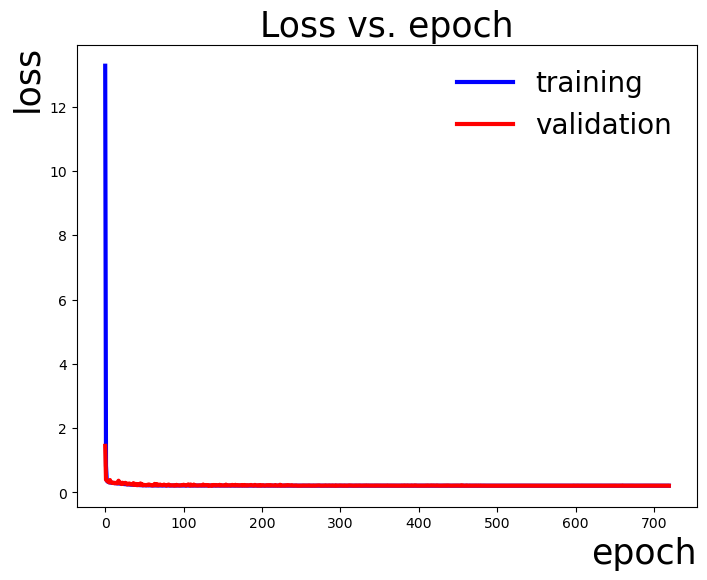

In [26]:
# plot loss function

fig, ax = plt.subplots(1,1, figsize=(8,6))

plt.plot(np.arange(0,epochs_1*iterations), list_loss, label='training',c='blue',linewidth = 3)
plt.plot(np.arange(0,epochs_1*iterations), list_val_loss, label='validation',c='red',linewidth = 3)

plt.title("Loss vs. epoch", fontsize=25)

ax.set_ylabel('loss', fontsize=25,horizontalalignment='right',y=1)
ax.set_xlabel('epoch', fontsize=25,horizontalalignment='right',x=1)
plt.legend(loc='best', prop={'size':20}, edgecolor = "w",fancybox=False, framealpha=0)

In [27]:
# Read the mean values
filename = 'outputs/models/%s/cbvae_LHCO2020_latent_mean_20d_e-6.csv'%folder_name
means_df = pd.read_csv(filename, sep=' ', header=None)
mean = means_df.values

# Read the std values
filename = 'outputs/models/%s/cbvae_LHCO2020_latent_std_20d_e-6.csv'%folder_name
stds_df = pd.read_csv(filename, sep=' ', header=None)
std = stds_df.values

z_samples = np.empty([cond_data.shape[0],latent_dim])

In [30]:
l=0
for i in range(0,cond_data.shape[0]):
    for j in range(0,latent_dim):
        z_samples[l,j] = np.random.normal(mean[i%trainsize,j], 0.05+std[i%trainsize,j])
    l=l+1
new_events = decoder.predict([z_samples, np.reshape(cond_data, [-1, 1])])
for i in range(0,new_events.shape[1]):
    new_events[:,i]=new_events[:,i]*feature_max[i]

os.system("mkdir -p ./outputs/gen_dataset/%s/"%folder_name)
np.savetxt('outputs/gen_dataset/%s/LHCO2020_cB-VAE_events_SB.csv'%folder_name, new_events)

In [31]:
file_gen_SB = 'outputs/gen_dataset/%s/LHCO2020_cB-VAE_events_SB.csv'%folder_name
gen_SB = pd.read_csv(file_gen_SB, delimiter = ' ', header=None, index_col=False)
gen_SB = gen_SB.to_numpy()
print("shape of gen_SR: ", gen_SB.shape)


shape of gen_SR:  (878648, 6)


In [32]:
# variables_names =  train_features
# vnames = train_features

plotting_ranges = [(0,0.8), (0,1), (0,1), (0,1), (0,1), (0,1)]

def fake_vs_real(gen_data,real_data,doLog,names):
    
    plt.figure(figsize=(20,15))
    colors = ["steelblue", "darkturquoise"]
    for p in range(0,nFeat):
        R = np.linspace(plotting_ranges[p][0],plotting_ranges[p][1],51)
        plt.subplot((nFeat+1)//2, 2, p+1)
        for rd in real_data: b_hist_y, b_hist_x, _ = plt.hist(rd[:,p], R, color="black", histtype='step', linewidth=2, label="SB Bkg", density=True)        
        for i,n in enumerate(gen_data): plt.hist(n[:,p], R, color=colors[i], histtype='stepfilled', alpha=0.5, linewidth=2, label="Generated Bkg %s"%names[i], density=True)
        # s_hist_y, s_hist_x, _ = plt.hist(sig_data[:,p], R, color="r", histtype='step', linewidth=3, label="Signal", density=True)
        plt.xlabel("%s"%feature_labels[p])
        if doLog == True: plt.yscale('log')
        plt.ylabel("Number of Events / bin")
        plt.legend(fontsize="large")
        ymax_b = np.max(b_hist_y)
        # ymax_s = np.max(s_hist_y)
        plt.ylim(0,ymax_b*1.5)
#     plt.savefig("fake_gen_compare_cbvae_6var_dynamicbeta.png")

In [36]:
cond_data.shape

(878648,)

/tmp/ipykernel_59556/2461113566.py:22: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim(0,ymax_b*1.5)


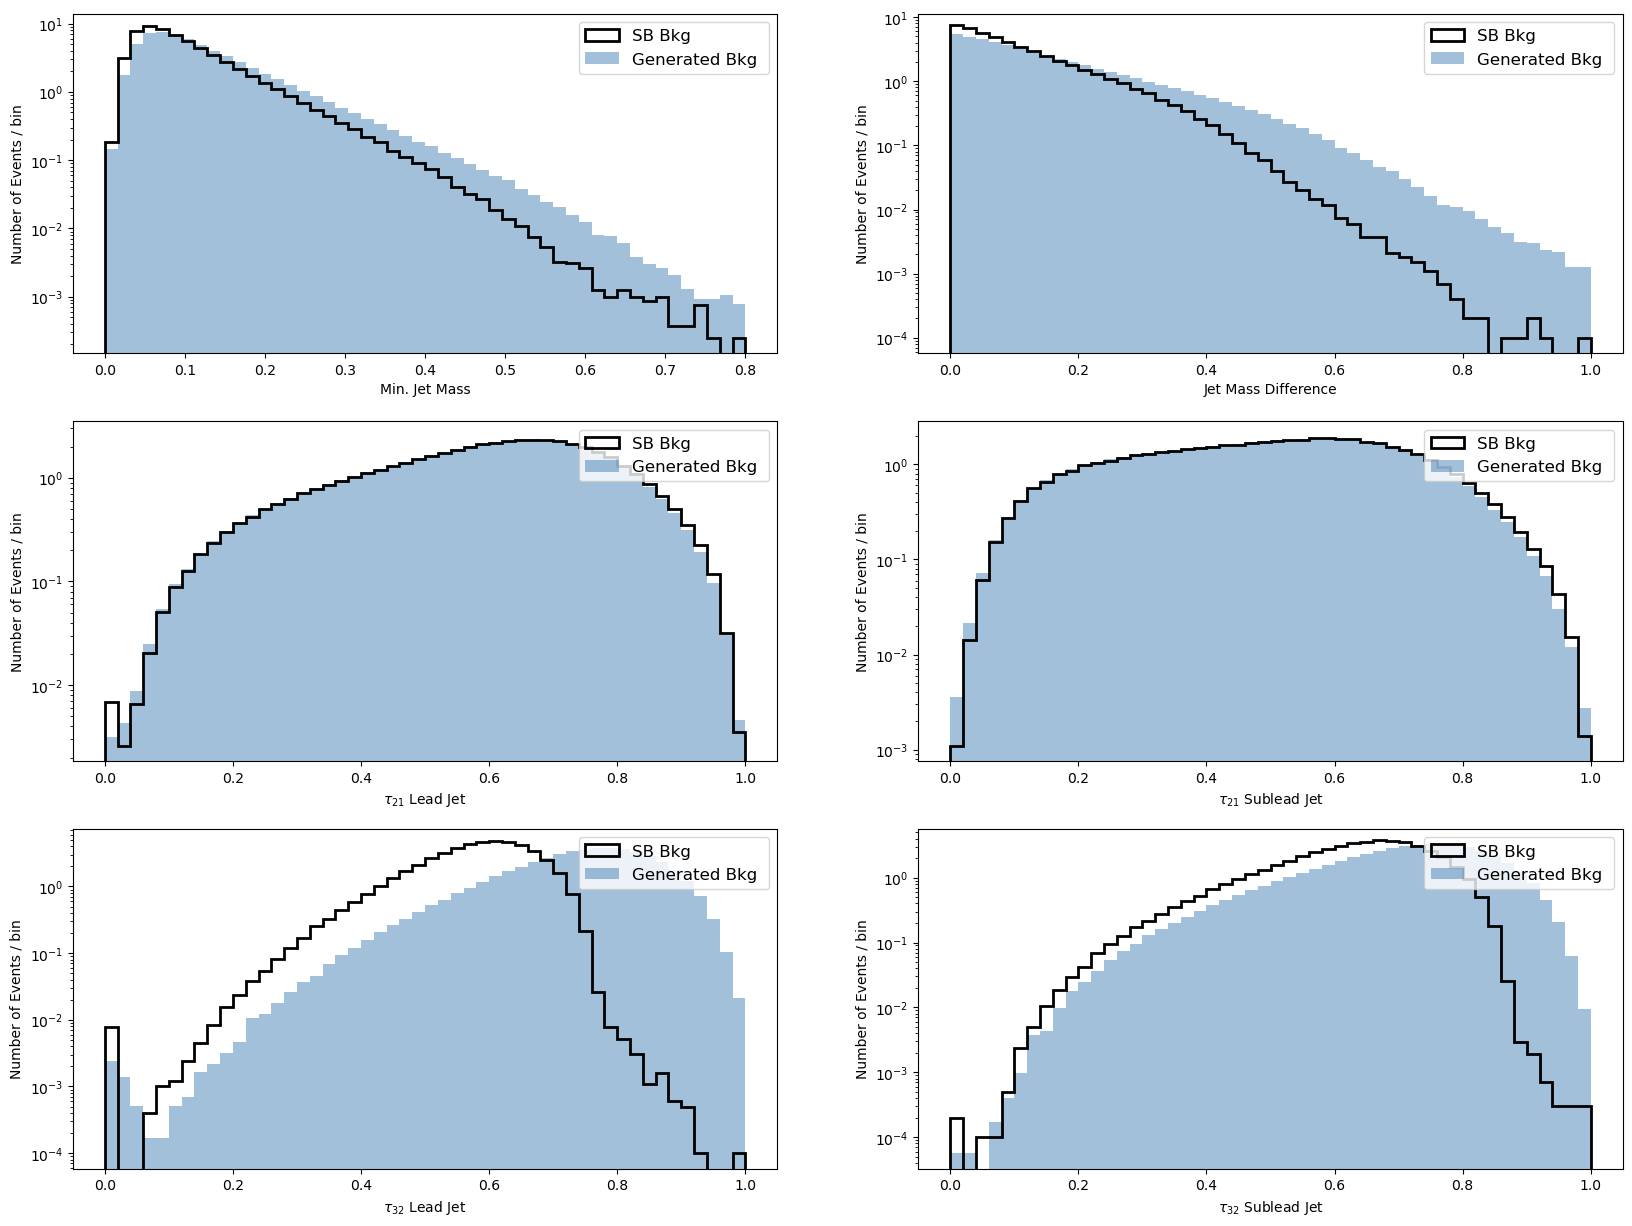

In [33]:
fake_vs_real([gen_SB],[x_train],1,[""])